<a href="https://colab.research.google.com/github/mailtopk/embeddingsbp/blob/main/Embeddings_bestPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!nvidia-smi

Sun Aug 31 01:28:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             31W /   70W |    2498MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#Setup
%pip install sentence-transformers


In [2]:
# Understand embeddings layer

import torch
import torch.nn as nn

class TransformerEmbeddings(nn.Module):
  def __init__(self, vocab_size, embedding_dim, max_length=512):
    super.__init__()

    # Token embeddings: convert words to vectors
    self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)

    # Positional embeddings: add sequence order information
    self.positional_embeddings = nn.Embedding(max_length, embedding_dim)

    # Segment embeddings: distinguish different parts of input (e.g., question vs context)
    self.segment_embeddings = nn.Embedding(2, embedding_dim)

    # Layer normalization
    self.layer_norm = nn.LayerNorm(embedding_dim)
    self.dropout = nn.Dropout(0.1)

  def forward(self, input_ids, segment_id=None):
    # Get sequance length from input
    seq_length = input_ids.size(1)

    # Create position IDs indices (0, 1, 2,..)
    position_ids = torch.arange(seq_length, device=input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

    #segment embedding, if non initialized to zero
    if segment_id is None:
      segment_id = torch.zeros_like(input_ids)

    # combine all embedings
    embeddings = (
        self.token_embeddings(input_ids) +
        self.positional_embeddings(position_ids) +
        self.sengment_embeddings(segment_id)
    )

    # Apply layer normalization and dropout
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)

    return embeddings




In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

monolingual_model = SentenceTransformer('all-MiniLM-L6-v2')
multilingual_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')



In [7]:
# Example sentences in different languages
sentences = {
    'english': "The weather is beautiful today.",
    'spanish': "El clima está hermoso hoy.",
    'french': "Le temps est magnifique aujourd'hui.",
    'german': "Das Wetter ist heute wunderschön."
}

# Function to compute similarity between embeddings
def compute_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

# Compare embeddings across languages
def compare_sentences(model, sentences):
    # Generate embeddings for all sentences
    embeddings = {
        lang: model.encode(text, convert_to_numpy=True)
        for lang, text in sentences.items()
    }

    # Compare each pair
    print(f"\nSimilarity scores for {model.__class__.__name__}:")
    for lang1 in sentences:
        for lang2 in sentences:
            if lang1 < lang2:  # avoid duplicate comparisons
                sim = compute_similarity(embeddings[lang1], embeddings[lang2])
                print(f"{lang1} vs {lang2}: {sim:.4f}")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multilingual_model = multilingual_model.to(device)
monolingual_model = monolingual_model.to(device)

# Test device
monolingual_model = monolingual_model
for model in [monolingual_model, multilingual_model]:
    compare_sentences(model, sentences)


Similarity scores for SentenceTransformer:
english vs spanish: 0.1565
english vs french: 0.1190
english vs german: 0.1472
french vs spanish: 0.3038
french vs german: 0.2329
german vs spanish: 0.0404

Similarity scores for SentenceTransformer:
english vs spanish: 0.9916
english vs french: 0.9766
english vs german: 0.9900
french vs spanish: 0.9801
french vs german: 0.9930
german vs spanish: 0.9877


In [10]:
# Example of batch processing for efficiency
texts = list(sentences.values())
batch_embeddings = multilingual_model.encode(texts, batch_size=8)
batch_embeddings

array([[-0.35319242, -0.08173984, -0.01260098, ...,  0.0598221 ,
         0.11287276,  0.06665527],
       [-0.34583592, -0.09804583, -0.01258651, ...,  0.0550659 ,
         0.1120597 ,  0.07015114],
       [-0.3260478 , -0.14656122, -0.01337153, ...,  0.06969073,
         0.11693197,  0.08681154],
       [-0.34187278, -0.1172059 , -0.01355953, ...,  0.05922513,
         0.11434709,  0.07827169]], dtype=float32)

In [ ]:
#Length Handling: Be aware of maximum sequence length

max_seq_length = model.max_seq_length
def chunk_text(text, max_length=max_seq_length):
    # Split into sentences or chunks
    chunks = [text[i:i + max_length] for i in range(0, len(text), max_length)]
    return chunks

# Process long document
long_text_embeddings = model.encode(chunk_text(long_document))

In [16]:
# Normalization: Consider normalizing embeddings for cosine similarity
# Makes cosine similarity calculations more efficient
# Ensures consistent similarity scores across different lengths of text
# Reduces the impact of text length on similarity calculations
# Important for comparing embeddings across different documents

embeddings = model.encode(list(sentences), normalize_embeddings=True)
embeddings

array([[-0.04567016,  0.00326327, -0.00472475, ...,  0.01196525,
        -0.00940966, -0.03085416],
       [-0.06772514, -0.01382657, -0.00457956, ...,  0.00126622,
         0.02872803, -0.000449  ],
       [-0.02946393,  0.02743342, -0.00471895, ...,  0.00393686,
         0.06189221, -0.01214308],
       [-0.06218855, -0.03281022, -0.00310089, ..., -0.04045001,
         0.04895798, -0.04151825]], dtype=float32)

In [ ]:
# Memory management
import gc
import torch

def process_large_dataset(sentences_dict, batch_size=32):

  if sentences_dict is None:
    return None

  if type(sentences_dict) is not dict:
    raise ValueError("Input must be a dictionary")

  embeddings = []
  sentences = list(sentences_dict.values()) # Get the values as a list
  num_sentences = len(sentences)

  for i in range(0, num_sentences, batch_size):
    batch_sentences = sentences[i:i+batch_size]
    batch_embeddings = model.encode(batch_sentences)
    embeddings.extend(batch_embeddings)

    # clear GPU
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

    gc.collect()
  return embeddings

process_large_dataset(sentences, batch_size=2)

## Zero Short Learning

In [2]:
from sentence_transformers import SentenceTransformer, util
import torch

class ZeroShortClassification:
  def __init__(self, model_name="all-mpnet-base-v2"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = SentenceTransformer(model_name, device=device)

  def classify(self, text, labels):
    text_embedding = self.model.encode(text, convert_to_tensor=True, normalize_embeddings=True)

    # Prepair label prompt
    label_prompts = [f"This text is about label {label}" for label in labels]
    print(label_prompts)

    # Encode label prompts
    label_embedding = self.model.encode(label_prompts, convert_to_tensor=True, normalize_embeddings=True)

    # calculate similarities
    similarities = util.pytorch_cos_sim(text_embedding, label_embedding)[0]

    results = {
        label: float(score)
        for label, score in zip(labels, similarities)
    }

    return results


classification = ZeroShortClassification()
text = "The new quantum computer can perform calculations in seconds that would take classical computers thousands of years."
labels = ["technology", "sports", "cooking", "politics"]

results = classification.classify(text, labels)
print("Zero-shot classification results:")
for labels, scores in sorted(results.items(), key=lambda x: x[1], reverse=True):
  print(f"{labels}: {scores:.4f}")



['This text is about label technology', 'This text is about label sports', 'This text is about label cooking', 'This text is about label politics']
Zero-shot classification results:
technology: 0.0904
cooking: 0.0000
politics: -0.0346
sports: -0.0473


In [5]:
text = "seahawks is professional American football team based in Seattle"
labels = ["technology", "sports", "cooking", "politics"]
results = classification.classify(text, labels)
print(f"Zero-shot classification results: {results}")
for labels, scores in sorted(results.items(), key=lambda x: x[1], reverse=True):
  print(f"{labels}: {scores:.4f}")


['This text is about label technology', 'This text is about label sports', 'This text is about label cooking', 'This text is about label politics']
Zero-shot classification results: {'technology': 0.12781697511672974, 'sports': 0.31689268350601196, 'cooking': 0.11538080871105194, 'politics': 0.15189498662948608}
sports: 0.3169
politics: 0.1519
technology: 0.1278
cooking: 0.1154


# Characteristics That Enable Zero-Shot Learning
- Contextual Understanding
- Semantic Relationships
- Cross-Modal Capabilities: Modern embedding layers can handle multiple modalities:

In [ ]:
# Example of how context affects embeddings
from sentence_transformers import SentenceTransformer, util
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('all-mpnet-base-v2', device=device )
texts = [
        "The bank by the river is been destroyed",
        "The bank approved my loan"
]
embeddings = model.encode(texts, normalize_embeddings=True)
embeddings


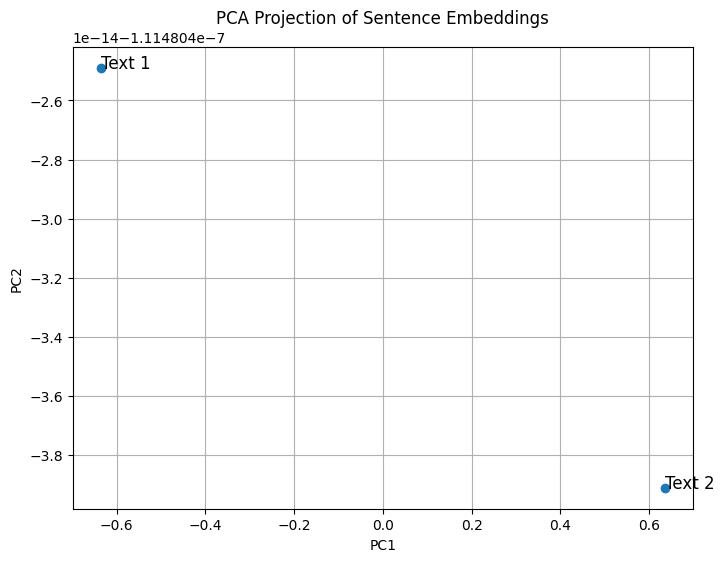

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], marker='o')

for i, text in enumerate(texts):
    plt.annotate(f"Text {i+1}", (reduced[i, 0], reduced[i, 1]), fontsize=12)

plt.title("PCA Projection of Sentence Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()